In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Race Track

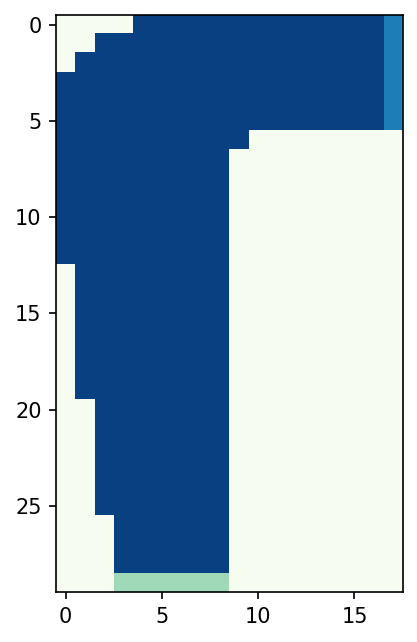

In [ ]:
track = np.zeros(shape=(30, 18))

# add race-track weight
# columns
track[1:26, 2] = 1
track[1:, 3] = 1
track[:, 4] = 1
track[:, 5] = 1
track[:, 6] = 1
track[:, 7] = 1
track[:, 8] = 1

track[3:13, 0] = 1
track[2:20, 1] = 1
track[6, 9] = 1

# rows
track[0, 4:] = 1
track[1, 5:] = 1
track[2, 4:] = 1
track[3, 4:] = 1
track[4, 4:] = 1
track[5, 4:] = 1



# add beginning
track[29, 3:9] = 0.4

# add end
track[0:6, 17] = 0.8


# plot race-track
plt.figure(figsize=(10, 5), dpi=150)
plt.imshow(track, cmap='GnBu')

### Environments

- RaceTrack
  - a

In [ ]:
class Environment:
    def __init__(self, racetrack):
        self.racetrack = racetrack
        self.done = False
        self.action_to_acceleration = {
            0: (-1, -1),
            1: (-1, 0),
            2: (-1, 1),
            3: (0, -1),
            4: (0, 0),
            5: (0, 1),
            6: (1, -1),
            7: (1, 0),
            8: (1, 1)
        }

    def reset(self):
        self.racetrack.reset_car()
        self.done = False
        return self._get_observation()

    def step(self, action):
        # Introduce noise with 0.1 probability
        if np.random.rand() < 0.1:
            acceleration = np.array([0, 0])
        else:
            acceleration = np.array(self.action_to_acceleration[action])

        self.racetrack.update_car(acceleration)

        if self.racetrack.check_off_track():
            self.racetrack.reset_car()
            reward = -1
            terminated = False  # Continue the episode after resetting
        elif self.racetrack.check_finish_line():
            self.done = True
            reward = 0
            terminated = True
        else:
            reward = -1
            terminated = False

        return self._get_observation(), reward, terminated

    def _get_observation(self):
        return (tuple(self.racetrack.position), tuple(self.racetrack.velocity))

In [ ]:
class Agent:
    def __init__(self, nA):
        self.nA = nA  # Number of possible actions (9 total)

    def behavior_policy(self, state_indices, target_pi, epsilon):
        if np.random.rand() < epsilon:
            action = np.random.randint(self.nA)
            prob = 1.0 / self.nA
        else:
            action = target_pi[state_indices]
            prob = 1 - epsilon + (epsilon / self.nA)
        return action, prob

In [ ]:
class RaceTrack:
    def __init__(self, track):
        self.track = track
        self.start_positions = np.argwhere(track == 0.4)
        self.finish_line = np.argwhere(track == 0.8)
        self.state = None
        self.speed = None

    def reset_car(self):
        # Reset car to a random start position and zero velocity
        start_idx = np.random.randint(0, len(self.start_positions))
        self.position = self.start_positions[start_idx]  # Random start position
        self.velocity = np.array([0, 0])  # Reset velocity to zero

    def update_car(self, velocity_change):
        # Apply the velocity change to both x and y components
        self.velocity = np.clip(self.velocity + velocity_change, 0, 4)
        self.position = np.clip(self.position + self.velocity, [0, 0], np.array(self.track.shape) - 1)

    def check_off_track(self):
        # Return True if car goes off the track (value is 0)
        return self.track[self.position[0], self.position[1]] == 0

    def check_finish_line(self):
        # Return True if car crosses the finish line (value is 0.8)
        return self.track[self.position[0], self.position[1]] == 0.8

    def render(self):
        # Render the racetrack using matplotlib
        plt.figure(figsize=(10, 5), dpi=150)
        plt.imshow(self.track, cmap='GnBu')

        # Plot the car on the racetrack
        plt.scatter(self.position[1], self.position[0], color='red', s=100, label='Car')  # Car's position

        plt.legend()
        plt.show()

### Behavior Policy

In [ ]:
def off_policy_monte_carlo(total_episodes, racetrack, epsilon=0.1, gamma=0.9):
    # Initialize the environment and agent
    env = Environment(racetrack)
    agent = Agent(nA=9)  # There are 9 possible actions

    # Initialize Q, C, and target policy
    observation_space = (racetrack.track.shape[0], racetrack.track.shape[1], 9, 9)  # Positions and velocities
    Q = np.random.normal(size=(*observation_space, agent.nA))  # Optimistic initialization
    Q -= 500  # Optimism in face of uncertainty
    C = np.zeros_like(Q)  # For importance sampling correction
    target_pi = np.argmax(Q, axis=-1)  # Shape is (rows, cols, 9, 9)

    reward_hist = np.zeros(total_episodes)

    for i in range(total_episodes):
        trajectory = []
        terminated = False
        state = env.reset()  # Reset environment and get initial state
        state_indices = get_state_indices(state)
        action, act_prob = agent.behavior_policy(state_indices, target_pi, epsilon)

        total_reward = 0
        while not terminated:
            observation, reward, terminated = env.step(action)
            total_reward += reward
            trajectory.append((state_indices, action, reward, act_prob))
            state = observation
            state_indices = get_state_indices(state)
            action, act_prob = agent.behavior_policy(state_indices, target_pi, epsilon)

        # Backward pass to update Q and target policy using importance sampling
        G = 0.0
        W = 1.0
        while trajectory:
            state_indices, action, reward, act_prob = trajectory.pop()
            G = gamma * G + reward
            C[state_indices][action] += W
            Q[state_indices][action] += (W / C[state_indices][action]) * (G - Q[state_indices][action])
            target_pi[state_indices] = np.argmax(Q[state_indices])  # Update policy to greedy action

            if action != target_pi[state_indices]:
                break  # Stop updating if action is not optimal
            W *= 1.0 / act_prob  # Update importance sampling weight

        reward_hist[i] = total_reward
        if i % 100 == 0:
            print(f'Episode: {i}, Total Reward: {total_reward}')

    return reward_hist, Q, target_pi

In [ ]:
def get_state_indices(state):
    position = state[0]
    velocity = state[1]
    row = position[0]
    col = position[1]
    velocity_x = velocity[0]
    velocity_y = velocity[1]
    velocity_x_index = velocity_x + 4  # Map from [-4, 4] to [0, 8]
    velocity_y_index = velocity_y + 4
    return (row, col, velocity_x_index, velocity_y_index)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Plot the result
def plot_result(reward_hist, total_episodes) -> None:
    plt.figure(figsize=(10, 6), dpi=150)
    plt.grid(c='lightgray')
    plt.margins(0.02)

    # Set axis properties
    for i, spine in enumerate(plt.gca().spines.values()):
        if i in [0, 2]:
            spine.set_linewidth(1.5)
            continue
        spine.set_visible(False)

    # Plot raw rewards
    x = np.arange(total_episodes)
    plt.plot(x, reward_hist, linewidth=1.2, label='Raw Rewards', color='tomato', alpha=0.6)

    # Plot smoothed rewards
    smoothed_rewards = uniform_filter1d(reward_hist, size=10)  # Use a window size of 10 for smoothing
    plt.plot(x, smoothed_rewards, linewidth=1.2, label='Smoothed Rewards', color='cornflowerblue')

    # Title and labels
    plt.title('Reward History over Episodes', fontsize=12, fontweight='bold')
    plt.xlabel('Episodes', fontsize=12, fontweight='bold')
    plt.ylabel('Total Reward', fontsize=12, fontweight='bold')

    # Show legend and plot
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def simulate_and_plot_trajectories(racetrack, policy, num_trajectories=1):
    env = Environment(racetrack)
    for trajectory in range(num_trajectories):
        state = env.reset()
        done = False
        plt.figure(figsize=(10, 5))
        plt.imshow(racetrack.track, cmap='GnBu')
        positions = [state[0]]  # Store positions to plot
        while not done:
            state_indices = get_state_indices(state)
            action = policy[state_indices]
            state, reward, done = env.step(action)
            positions.append(state[0])
            if done:
                break
        positions = np.array(positions)
        plt.scatter(positions[:, 1], positions[:, 0], c='red', s=10, label='Trajectory {}'.format(trajectory + 1))
        plt.title('Trajectory A')
        plt.show()


In [ ]:
# Track A
track = np.zeros(shape=(30, 18))

# add race-track weight
# columns
track[1:26, 2] = 1
track[1:, 3] = 1
track[:, 4] = 1
track[:, 5] = 1
track[:, 6] = 1
track[:, 7] = 1
track[:, 8] = 1

track[3:13, 0] = 1
track[2:20, 1] = 1
track[6, 9] = 1

# rows
track[0, 4:] = 1
track[1, 5:] = 1
track[2, 4:] = 1
track[3, 4:] = 1
track[4, 4:] = 1
track[5, 4:] = 1

# add beginning
track[29, 3:9] = 0.4

# add end
track[0:6, 17] = 0.8

racetrack = RaceTrack(track)

# Train using Off-policy Monte Carlo
total_episodes = 10
history, Q, pi_t = off_policy_monte_carlo(total_episodes, racetrack)

KeyboardInterrupt: 

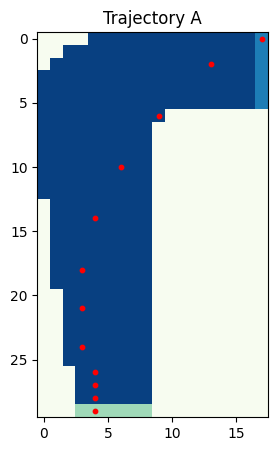

In [ ]:
simulate_and_plot_trajectories(racetrack, pi_t)

Episode: 0, Total Reward: -425
Episode: 100, Total Reward: -83
Episode: 200, Total Reward: -27
Episode: 300, Total Reward: -42
Episode: 400, Total Reward: -30
Episode: 500, Total Reward: -22
Episode: 600, Total Reward: -34
Episode: 700, Total Reward: -9
Episode: 800, Total Reward: -51
Episode: 900, Total Reward: -27
Episode: 1000, Total Reward: -11
Episode: 1100, Total Reward: -12
Episode: 1200, Total Reward: -11
Episode: 1300, Total Reward: -42
Episode: 1400, Total Reward: -11
Episode: 1500, Total Reward: -20
Episode: 1600, Total Reward: -20
Episode: 1700, Total Reward: -20
Episode: 1800, Total Reward: -17
Episode: 1900, Total Reward: -20
Episode: 2000, Total Reward: -34
Episode: 2100, Total Reward: -10
Episode: 2200, Total Reward: -40
Episode: 2300, Total Reward: -30
Episode: 2400, Total Reward: -23
Episode: 2500, Total Reward: -96
Episode: 2600, Total Reward: -11
Episode: 2700, Total Reward: -19
Episode: 2800, Total Reward: -9
Episode: 2900, Total Reward: -25
Episode: 3000, Total Re

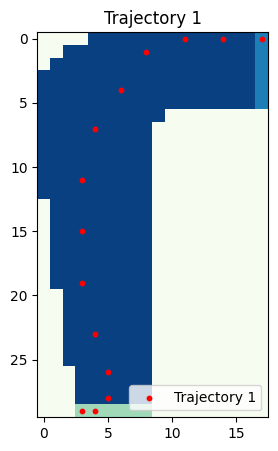

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d



class Environment:
    def __init__(self, racetrack):
        self.racetrack = racetrack
        self.done = False
        self.action_to_acceleration = {
            0: (-1, -1),
            1: (-1, 0),
            2: (-1, 1),
            3: (0, -1),
            4: (0, 0),
            5: (0, 1),
            6: (1, -1),
            7: (1, 0),
            8: (1, 1)
        }

    def reset(self):
        self.racetrack.reset_car()
        self.done = False
        return self._get_observation()

    def step(self, action):
        # Introduce noise with 0.1 probability
        if np.random.rand() < 0.1:
            acceleration = np.array([0, 0])
        else:
            acceleration = np.array(self.action_to_acceleration[action])

        self.racetrack.update_car(acceleration)

        if self.racetrack.check_off_track():
            self.racetrack.reset_car()
            reward = -1
            terminated = False  # Continue the episode after resetting
        elif self.racetrack.check_finish_line():
            self.done = True
            reward = 0
            terminated = True
        else:
            reward = -1
            terminated = False

        return self._get_observation(), reward, terminated

    def _get_observation(self):
        return (tuple(self.racetrack.position), tuple(self.racetrack.velocity))


class Agent:
    def __init__(self, nA):
        self.nA = nA  # Number of possible actions (9 total)

    def behavior_policy(self, state_indices, target_pi, epsilon):
        if np.random.rand() < epsilon:
            action = np.random.randint(self.nA)
            prob = 1.0 / self.nA
        else:
            action = target_pi[state_indices]
            prob = 1 - epsilon + (epsilon / self.nA)
        return action, prob


class RaceTrack:
    def __init__(self, track):
        self.track = track
        self.start_positions = np.argwhere(track == 0.4)
        self.finish_line = np.argwhere(track == 0.8)
        self.state = None
        self.speed = None

    def reset_car(self):
        # Reset car to a random start position and zero velocity
        start_idx = np.random.randint(0, len(self.start_positions))
        self.position = self.start_positions[start_idx]  # Random start position
        self.velocity = np.array([0, 0])  # Reset velocity to zero

    def update_car(self, velocity_change):
        # Apply the velocity change to both x and y components
        self.velocity = np.clip(self.velocity + velocity_change, -4, 4)  # Allow negative velocities
        self.position = np.clip(self.position + self.velocity, [0, 0], np.array(self.track.shape) - 1)

    def check_off_track(self):
        # Return True if car goes off the track (value is 0)
        return self.track[self.position[0], self.position[1]] == 0

    def check_finish_line(self):
        # Return True if car crosses the finish line (value is 0.8)
        return self.track[self.position[0], self.position[1]] == 0.8

    def render(self):
        # Render the racetrack using matplotlib
        plt.figure(figsize=(10, 5), dpi=150)
        plt.imshow(self.track, cmap='GnBu')

        # Plot the car on the racetrack
        plt.scatter(self.position[1], self.position[0], color='red', s=100, label='Car')  # Car's position

        plt.legend()
        plt.show()




class OffPolicyMonteCarlo:
    def __init__(self, racetrack, total_episodes, epsilon=0.1, gamma=0.9):
        self.racetrack = racetrack
        self.total_episodes = total_episodes
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = Environment(racetrack)
        self.agent = Agent(nA=9)  # Assuming there are 9 possible actions

        # Initialize Q, C, and target policy
        observation_space = (racetrack.track.shape[0], racetrack.track.shape[1], 9, 9)
        self.Q = np.random.normal(size=(*observation_space, self.agent.nA))
        self.Q -= 500  # Optimism in face of uncertainty
        self.C = np.zeros_like(self.Q)
        self.target_pi = np.argmax(self.Q, axis=-1)

    def get_state_indices(self, state):
        position, velocity = state
        row, col = position
        velocity_x, velocity_y = velocity
        velocity_x_index = velocity_x + 4
        velocity_y_index = velocity_y + 4
        return (row, col, velocity_x_index, velocity_y_index)

    def train(self):
        reward_hist = np.zeros(self.total_episodes)
        for i in range(self.total_episodes):
            trajectory = []
            terminated = False
            state = self.env.reset()
            state_indices = self.get_state_indices(state)
            action, act_prob = self.agent.behavior_policy(state_indices, self.target_pi, self.epsilon)

            total_reward = 0
            while not terminated:
                observation, reward, terminated = self.env.step(action)
                total_reward += reward
                trajectory.append((state_indices, action, reward, act_prob))
                state = observation
                state_indices = self.get_state_indices(state)
                action, act_prob = self.agent.behavior_policy(state_indices, self.target_pi, self.epsilon)

            # Update Q-values and policy via backward pass (importance sampling)
            G = 0.0
            W = 1.0
            for state_indices, action, reward, act_prob in reversed(trajectory):
                G = self.gamma * G + reward
                self.C[state_indices][action] += W
                self.Q[state_indices][action] += (W / self.C[state_indices][action]) * (G - self.Q[state_indices][action])
                self.target_pi[state_indices] = np.argmax(self.Q[state_indices])

                if action != self.target_pi[state_indices]:
                    break
                W /= act_prob

            reward_hist[i] = total_reward
            if i % 100 == 0:
                print(f'Episode: {i}, Total Reward: {total_reward}')

        return reward_hist, self.Q, self.target_pi

    def simulate_and_plot_trajectories(self, num_trajectories=1):
        for trajectory in range(num_trajectories):
            state = self.env.reset()
            done = False
            positions = [state[0]]
            while not done:
                state_indices = self.get_state_indices(state)
                action = self.target_pi[state_indices]
                state, reward, done = self.env.step(action)
                positions.append(state[0])

            positions = np.array(positions)
            plt.figure(figsize=(10, 5))
            plt.imshow(self.racetrack.track, cmap='GnBu')
            plt.scatter(positions[:, 1], positions[:, 0], c='red', s=10, label=f'Trajectory {trajectory + 1}')
            plt.title('Trajectory {}'.format(trajectory + 1))
            plt.legend()
            plt.show()



def trackA():
    track = np.zeros(shape=(30, 18))
    track[1:26, 2] = 1
    track[1:, 3] = 1
    track[:, 4] = 1
    track[:, 5] = 1
    track[:, 6] = 1
    track[:, 7] = 1
    track[:, 8] = 1
    track[3:13, 0] = 1
    track[2:20, 1] = 1
    track[6, 9] = 1
    track[0, 4:] = 1
    track[1, 5:] = 1
    track[2, 4:] = 1
    track[3, 4:] = 1
    track[4, 4:] = 1
    track[5, 4:] = 1
    track[29, 3:9] = 0.4
    track[0:6, 17] = 0.8

    racetrack = RaceTrack(track)
    monte_carlo = OffPolicyMonteCarlo(racetrack, total_episodes=10000)
    reward_history, Q_values, policy = monte_carlo.train()
    monte_carlo.simulate_and_plot_trajectories(num_trajectories=1)



def main():
    trackA()


if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.use('Agg')

# 2 actions
ACTIONS = [0, 1]

# each transition has a probability to terminate with 0
TERMINATION_PROB = 0.1

# maximum expected updates
MAX_STEPS = 20000

# epsilon greedy for behavior policy
EPSILON = 0.1


# break tie randomly
def argmax(value):
    max_q = np.max(value)
    return np.random.choice([a for a, q in enumerate(value) if q == max_q])


class Task:
    # @n_states: number of non-terminal states
    # @b: branch
    # Each episode starts with state 0, and state n_states is a terminal state
    def __init__(self, n_states, b):
        self.n_states = n_states
        self.b = b

        # transition matrix, each state-action pair leads to b possible states
        self.transition = np.random.randint(n_states, size=(n_states, len(ACTIONS), b))

        # it is not clear how to set the reward, I use a unit normal distribution here
        # reward is determined by (s, a, s')
        self.reward = np.random.randn(n_states, len(ACTIONS), b)

    def step(self, state, action):
        if np.random.rand() < TERMINATION_PROB:
            return self.n_states, 0
        next_ = np.random.randint(self.b)
        return self.transition[state, action, next_], self.reward[state, action, next_]


# Evaluate the value of the start state for the greedy policy
# derived from @q under the MDP @task
def evaluate_pi(q, task):
    # use Monte Carlo method to estimate the state value
    runs = 1000
    returns = []
    for r in range(runs):
        rewards = 0
        state = 0
        while state < task.n_states:
            action = argmax(q[state])
            state, r = task.step(state, action)
            rewards += r
        returns.append(rewards)
    return np.mean(returns)


# perform expected update from a uniform state-action distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def uniform(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    for step in tqdm(range(MAX_STEPS)):
        state = step // len(ACTIONS) % task.n_states
        action = step % len(ACTIONS)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance)


# perform expected update from an on-policy distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def on_policy(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    state = 0
    for step in tqdm(range(MAX_STEPS)):
        if np.random.rand() < EPSILON:
            action = np.random.choice(ACTIONS)
        else:
            action = argmax(q[state])

        next_state, _ = task.step(state, action)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if next_state == task.n_states:
            next_state = 0
        state = next_state

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance)


def figure_8_8():
    num_states = [1000, 10000]
    branch = [1, 3, 10]
    methods = [on_policy, uniform]

    # average across 30 tasks
    n_tasks = 30

    # number of evaluation points
    x_ticks = 100

    plt.figure(figsize=(10, 20))
    for i, n in enumerate(num_states):
        plt.subplot(2, 1, i+1)
        for b in branch:
            tasks = [Task(n, b) for _ in range(n_tasks)]
            for method in methods:
                steps = None
                value = []
                for task in tasks:
                    steps, v = method(task, MAX_STEPS / x_ticks)
                    value.append(v)
                value = np.mean(np.asarray(value), axis=0)
                plt.plot(steps, value, label=f'b = {b}, {method.__name__}')
        plt.title(f'{n} states')

        plt.ylabel('value of start state')
        plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('computation time, in expected updates')

    plt.show()


if __name__ == '__main__':
    figure_8_8()

100%|██████████| 20000/20000 [00:29<00:00, 682.53it/s]
